In [1]:
import os
import sys

seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

from tensorflow.random import set_seed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from keras.models import load_model

In [3]:
# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [65]:
from src.data_reader import DataReader
from src.metrics import compute_evaluation_metrics
from src.model import create_mlp_model, get_callbacks
from src.model_evaluation import evaluate_mlp_multiple_splits
from src.plotting import plot_loss_curves
from src.save_object import load_object, save_object
from src.training import train_evaluate_mlp, MLPConfigParams
from src.utils import numbers_list_to_string

In [5]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [6]:
# Set input and output paths
filename = '../data/N-CMAPSS_DS02-006.h5'
output_path = '../results/experiment_set_16'

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [28]:
def grid_search(output_path):
    param_grid = {"max_depth": [2, 3, 4, 5],
                  "max_features": ["auto", "sqrt", "log2"],
                  "n_estimators": [50, 100, 200, 300],
                  "criterion": ["gini", "entropy"]}

    clf = RandomForestClassifier(verbose=0, n_jobs=4)

    grid_search = GridSearchCV(clf, cv=3, param_grid=param_grid, verbose=2)
    start = time.time()
    grid_search.fit(X_train_split, y_train_split)
    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
          % (time.time() - start, len(grid_search.cv_results_)))
    save_object(grid_search, os.path.join(output_path, "grid_search.pkl"))
    
def train_classifier(X, y, clf_params):
    clf = RandomForestClassifier(n_estimators=clf_params["n_estimators"],
                                 max_depth=clf_params["max_depth"], 
                                 max_features=clf_params["max_features"],
                                 criterion=clf_params["criterion"],
                                 n_jobs=4)
    clf.fit(X, y)
    return clf

def evaluate_classifier(X, y, clf):
    predictions = clf.predict_proba(X)[:, 1]
    roc_auc = roc_auc_score(y, predictions)
    print('ROC-AUC:', roc_auc)

In [8]:
data_reader = DataReader()

start_time = time.process_time()  
data_reader.load_dataset(filename, load_train=True, load_test=True)
print("Operation time (sec): " , (time.process_time() - start_time))

if data_reader.train_set is not None:
    print("Train set shape: " + str(data_reader.train_set.shape))
    
if data_reader.test_set is not None:   
    print("Test set shape: " + str(data_reader.test_set.shape))

Operation time (sec):  4.484375
Train set shape: (5263447, 47)
Test set shape: (1253743, 47)


In [13]:
train_set = data_reader.train_set
test_set = data_reader.test_set

In [14]:
selected_columns = data_reader.column_names.w_cols + data_reader.column_names.x_s_cols
train_set = train_set[selected_columns]
test_set = test_set[selected_columns]

In [17]:
N = 10 ** 6

# Select N samples from training and test sets
train_sample = train_set.sample(n=N, random_state=seed)
test_sample = test_set.sample(n=N, random_state=seed)
    
# Add classifier target column
train_sample['is_test'] = 0
test_sample['is_test'] = 1
    
# Concatenate datasets
dataset_sample = pd.concat([train_sample, test_sample], ignore_index=True, axis=0)
labels = dataset_sample['is_test'].values
dataset_sample = dataset_sample.drop('is_test', axis=1).values
    
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(dataset_sample, 
                                                                            labels, 
                                                                            test_size=0.3, 
                                                                            random_state=seed,
                                                                            stratify=labels)

In [22]:
grid_search = load_object(os.path.join(output_path, "grid_search.pkl"))
grid_search_results = pd.DataFrame(grid_search.cv_results_)
best_params = grid_search.best_params_

In [25]:
clf = train_classifier(x_train_split, y_train_split, best_params)

In [26]:
clf

RandomForestClassifier(max_depth=5, max_features='log2', n_jobs=4)

In [29]:
evaluate_classifier(x_test_split, y_test_split, clf)

ROC-AUC: 0.6843923489


In [64]:
best_params

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 100}

<AxesSubplot:xlabel='Computed sample weight', ylabel='# Samples'>

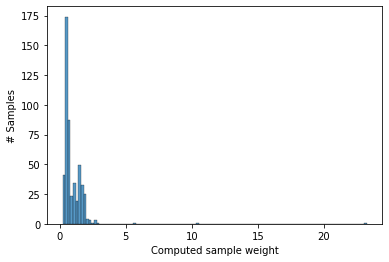

In [32]:
predictions_train = clf.predict_proba(dataset_sample[:500])[:, 1]
weights = (1./predictions_train) - 1. 
weights /= np.mean(weights)
plt.xlabel('Computed sample weight')
plt.ylabel('# Samples')
sns.histplot(weights, kde=False)

In [33]:
save_object(clf, os.path.join(output_path, "classifier.pkl"))

Saved object to file: ../results/experiment_set_16\classifier.pkl


In [34]:
##################################
# Experiment 16 (sample weighting)
##################################
train_set = data_reader.train_set
test_set = data_reader.test_set

y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)

In [35]:
clf = load_object(os.path.join(output_path, "classifier.pkl"))

In [36]:
selected_columns = data_reader.column_names.w_cols + data_reader.column_names.x_s_cols
x_train = x_train[selected_columns]
x_test = x_test[selected_columns]

In [37]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [49]:
class_pb = clf.predict_proba(x_train)[:, 1]

In [50]:
# weights = (1. / class_pb) - 1. 
# weights /= np.mean(weights)

weights = class_pb

<AxesSubplot:xlabel='Computed sample weight', ylabel='# Samples'>

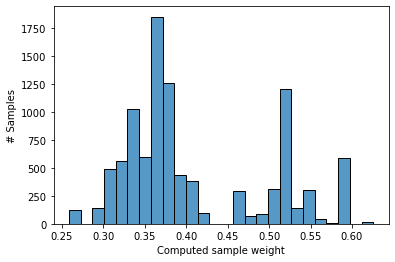

In [51]:
plt.xlabel('Computed sample weight')
plt.ylabel('# Samples')
sns.histplot(weights[:10000], kde=False)

In [52]:
weights = pd.DataFrame(weights)

In [61]:
def train_evaluate_mlp_sample_weights(x_train, y_train, 
                                      x_test, y_test,
                                      sample_weights,
                                      num_trials,
                                      mlp_config_params, 
                                      results_path, 
                                      epochs, batch_size, results_file=None):

    mse_vals = []
    rmse_vals = []
    cmapss_vals = []

    input_dim = x_train.shape[1]

    for trial_num in range(num_trials):
        # Create results path for current split
        results_path_crr_split = os.path.join(results_path, "split_{}".format(trial_num))
        if not os.path.exists(results_path_crr_split):
            os.makedirs(results_path_crr_split)

        # Train-validation split for early stopping
        x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train,
                                                                                  y_train,
                                                                                  test_size=0.1,
                                                                                  random_state=trial_num)


        train_weights = sample_weights.loc[x_train_split.index]
        val_weights = sample_weights.loc[x_val_split.index]
        
        # Standardization
        scaler_file = os.path.join(results_path_crr_split, 'scaler.pkl')
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_split)
        x_val_scaled = scaler.transform(x_val_split)
        save_object(scaler, scaler_file)

        weights_file = os.path.join(results_path, 'mlp_initial_weights.h5')
        model_path = os.path.join(results_path_crr_split, 'mlp_model_trained.h5')

        # Initialize weights only in first split
        if trial_num == 0:
            model = create_mlp_model(input_dim,
                                     hidden_layer_sizes=mlp_config_params.layer_sizes,
                                     activation=mlp_config_params.activation,
                                     dropout=mlp_config_params.dropout,
                                     output_weights_file=weights_file)
        else:
            model = create_mlp_model(input_dim,
                                     hidden_layer_sizes=mlp_config_params.layer_sizes,
                                     activation=mlp_config_params.activation,
                                     dropout=mlp_config_params.dropout)
        model.summary()

        # Train model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)
        history = model.fit(x_train_scaled, y_train_split,
                            validation_data=(x_val_scaled, y_val_split, val_weights),
                            sample_weight=train_weights,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=get_callbacks(model_path))

        history_file = os.path.join(results_path_crr_split, f"history_{trial_num}.pkl")
        plot_loss_curves(history.history)
        save_object(history.history, history_file)

        # Performance evaluation
        x_test_scaled = scaler.transform(x_test)
        loaded_model = load_model(model_path)  # load model saved by checkpoint
        predictions_test = loaded_model.predict(x_test_scaled).flatten()
        mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)

        mse_vals.append(mse)
        rmse_vals.append(rmse)
        cmapss_vals.append(cmapss_score)

    mse_mean = np.mean(mse_vals)
    mse_std = np.std(mse_vals)
    rmse_mean = np.mean(rmse_vals)
    rmse_std = np.std(rmse_vals)
    cmapss_mean = np.mean(cmapss_vals)
    cmapss_std = np.std(cmapss_vals)

    if results_file is not None:
        with open(results_file, "a") as file:
            line_to_write = f"{numbers_list_to_string(mse_vals)}, {numbers_list_to_string(rmse_vals)},"
            line_to_write += f"{numbers_list_to_string(cmapss_vals)}, {mse_mean}, {mse_std}, {rmse_mean},"
            line_to_write += f"{rmse_std}, {cmapss_mean}, {cmapss_std}\n"
            file.write(line_to_write)

    print("MSE: mean = {:.2f}   stddev = {:.2f}".format(mse_mean, mse_std))
    print("RMSE: mean = {:.2f}   stddev = {:.2f}".format(rmse_mean, rmse_std))
    print("CMAPSS: mean = {:.2f}   stddev = {:.2f}".format(cmapss_mean, cmapss_std))

    return mse_vals, rmse_vals, cmapss_vals

Saved object to file: ../results/experiment_set_16\result_weights\split_0\scaler.pkl
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable params: 235,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
9250/9253 [=======

9248/9253 [============================>.] - ETA: 0s - loss: 9.5638
Epoch 00027: val_loss did not improve from 8.96241
9253/9253 [==============================] - 38s 4ms/step - loss: 9.5635 - val_loss: 10.9089
Epoch 28/60
9241/9253 [============================>.] - ETA: 0s - loss: 9.3381
Epoch 00028: val_loss did not improve from 8.96241
9253/9253 [==============================] - 38s 4ms/step - loss: 9.3367 - val_loss: 9.5500
Epoch 00028: early stopping


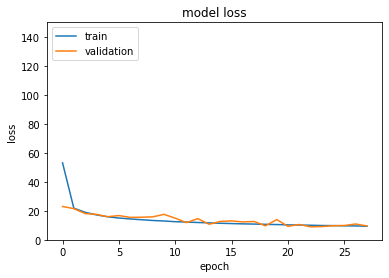

Saved object to file: ../results/experiment_set_16\result_weights\split_0\history_0.pkl
Test set:
MSE: 64.52
RMSE: 8.03
CMAPSS score: 1.81

Saved object to file: ../results/experiment_set_16\result_weights\split_1\scaler.pkl
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 235,137
Train

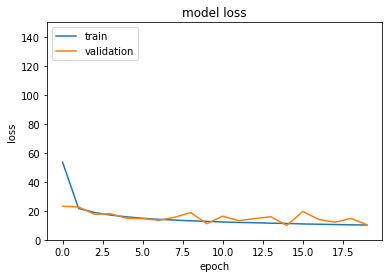

Saved object to file: ../results/experiment_set_16\result_weights\split_1\history_1.pkl
Test set:
MSE: 59.24
RMSE: 7.70
CMAPSS score: 1.75

Saved object to file: ../results/experiment_set_16\result_weights\split_2\scaler.pkl
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 235,137
Train

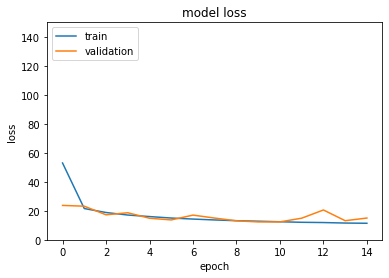

Saved object to file: ../results/experiment_set_16\result_weights\split_2\history_2.pkl
Test set:
MSE: 63.07
RMSE: 7.94
CMAPSS score: 1.79

MSE: mean = 62.28   stddev = 2.23
RMSE: mean = 7.89   stddev = 0.14
CMAPSS: mean = 1.78   stddev = 0.02


([64.51611, 59.24249, 63.0728],
 [8.032192, 7.696914, 7.9418387],
 [1.805839793322874, 1.7458514225004647, 1.7861469615383696])

In [63]:
# Train single MLP
EPOCHS = 60
BATCH_SIZE = 512
NUM_TRIALS = 3
mlp_config_params = MLPConfigParams(layer_sizes=[256, 256, 512, 64], activation='tanh', dropout=0.0)

results_path = os.path.join(output_path, f"result_weights")
if not os.path.exists(results_path):
    os.makedirs(results_path)

train_evaluate_mlp_sample_weights(
        x_train, y_train, 
        x_test, y_test,
        weights,
        NUM_TRIALS,
        mlp_config_params, 
        results_path, 
        EPOCHS, BATCH_SIZE)

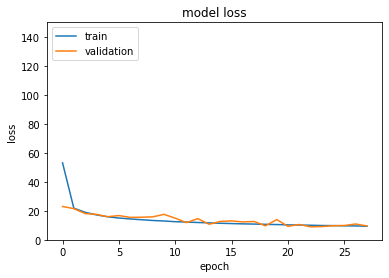

Test set:
MSE: 64.52
RMSE: 8.03
CMAPSS score: 1.81



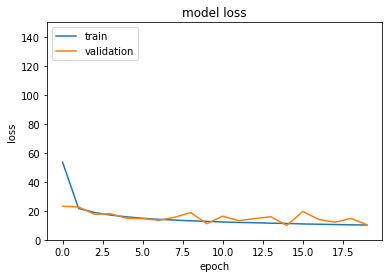

Test set:
MSE: 59.24
RMSE: 7.70
CMAPSS score: 1.75



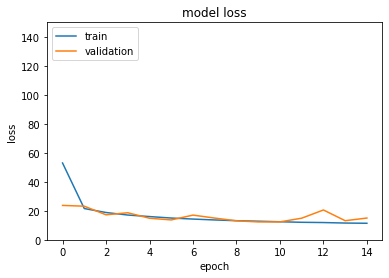

Test set:
MSE: 63.07
RMSE: 7.94
CMAPSS score: 1.79

MSE: mean = 62.28   stddev = 2.23
RMSE: mean = 7.89   stddev = 0.14
CMAPSS: mean = 1.78   stddev = 0.02


In [66]:
# Evaluate
NUM_TRIALS = 3
TRAIN_RESULTS_PATH = os.path.join(output_path, f"result_weights")

results = evaluate_mlp_multiple_splits(x_test, y_test, NUM_TRIALS, TRAIN_RESULTS_PATH, plot_loss=True)